In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
    
def get_memory(results, ax, label, rank="1", ls='-', color='black', marker='', lw=1):
    op = 'DBMemorySize'
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', label])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    df[label] = df[label].astype(int)
    df.plot(ax=ax, y=[label], x='shift', color=color, ls=ls, lw=lw, marker=marker, markersize=5, markevery=50)
    print df.tail(1)
    return df
font = {'size'   : 15}
matplotlib.rc('font', **font)


               ts            op  No Cache Management    shift
37479  1504434487  DBMemorySize           1047059640  14990.0
               ts            op  Cache (hand-tuned)    shift
37529  1504464554  DBMemorySize           462584448  15011.0
               ts            op  Cache (too small)    shift
37479  1504449527  DBMemorySize              33440  15013.0
               ts            op  Our Solution (Section 5)    shift
36004  1510572715  DBMemorySize                 129803952  15001.0


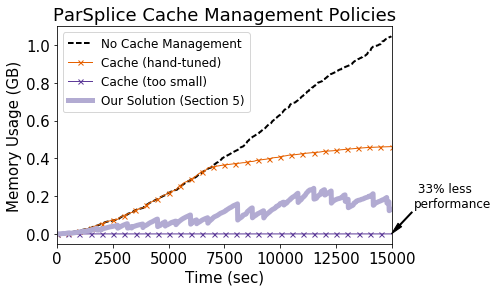

In [24]:
RGDETECT = "../nano/scale-workers-8-162696/"
LRU10    = "../baseline/scale-cachelimit-8n-10-72001-LRU"
LRU100K  = "../baseline/scale-cachelimit-8n-100000-72005-LRU"
#TPOLICY  = "../baseline/scale-cachedecrease-8n-10-72376"
#TPOLICY  = "../baseline/scale-cachedecrease-8n-100-7237"
#TPOLICY  = "../baseline/scale-cachedecrease-8n-1000-72378"
TPOLICY  = "../baseline/scale-cachedecrease-8n-10000-72374"
#TPOLICY  = "../baseline/scale-cachelimit-8n-100000-71993"
BASELINE = "../baseline/scale-cachelimit-8n-unlimited-71994"

fig, ax = plt.subplots(1, 1)
get_memory(BASELINE, ax, "No Cache Management", "1", ls='--', lw=2)
get_memory(LRU100K,  ax, "Cache (hand-tuned)", "1", color='#e66101', marker='x')
get_memory(LRU10,    ax, "Cache (too small)", "1", color='#5e3c99', marker='x' )
#get_memory(TPOLICY,  ax, "Two Part Policy (-17%)", "1", ls='--')
get_memory(RGDETECT, ax, "Our Solution (Section 5)", "4", color='#b2abd2', lw=5)
#ax.set_xlim(0, 18000)
ax.annotate(' 33% less\nperformance', xytext=(16000, 0.2*1000*1000*1000), xy=(15000, 0.001*1000*1000*1000), fontsize=12, ha='left', va='center',
           arrowprops=dict(facecolor='black', width=1, headwidth=5))
#ax.annotate('17%', xytext=(16000, 0.15*1000*1000*1000), xy=(15000, 0.05*1000*1000*1000), fontsize=15, ha='left', va='center',
#           arrowprops=dict(facecolor='black',  width=1, headwidth=5))
#ax.annotate(' 0%', xytext=(16000, 0.3*1000*1000*1000), xy=(15000, 0.2*1000*1000*1000), fontsize=15, ha='left', va='center',
#           arrowprops=dict(facecolor='black',  width=1, headwidth=5))
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Memory Usage (GB)")
ax.set_title("ParSplice Cache Management Policies")
ax.legend(fontsize=12)
x = ax.set_yticklabels(['{:3.1f}'.format(yval/(1000*1000*1000)) for yval in ax.get_yticks()])
fig.savefig("../../../paper/figures/cache-management.png", bbox_inches='tight', dpi=400)


In [ ]:
def plot_times(ax, label, results):
    #colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    print df.tail(1)
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
fig, ax = plt.subplots(1, 1)
plot_times(ax, "Baseline", BASELINE)
plot_times(ax, "LRU10", LRU10)
plot_times(ax, "Hand-Tuned Policy", TPOLICY)
plot_times(ax, "Regime Detection Policy", RGDETECT)
